<a href="https://colab.research.google.com/github/jsumbo/Group_2_Sentiment_Analysis_Project/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📚 IMPORTS
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_curve, auc)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Citations
# Dataset: S. Shahane, “Twitter Sentiment Dataset,” Kaggle, Jan 2020.
# NLTK: Bird et al., “Natural Language Processing with Python,” O’Reilly, 2009.

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load and inspect data
df = pd.read_csv('Twitter_Data.csv')
df = df[['clean_text', 'category']].dropna()
df = df[df.category.isin([1, -1])]
df['sentiment'] = df['category'].map({1: 1, -1: 0})

print("Rows:", df.shape[0])
print(df['sentiment'].value_counts())

Rows: 107758
sentiment
1    72249
0    35509
Name: count, dtype: int64


EDA

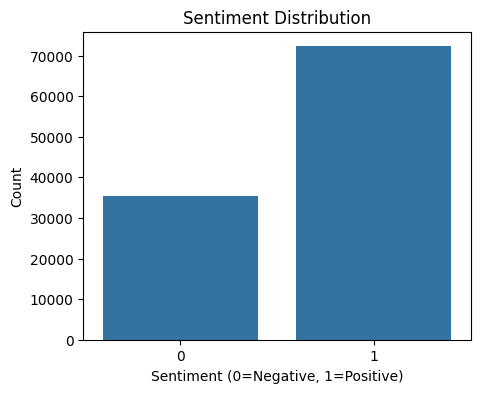

In [ ]:
# A) Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count'); plt.show()

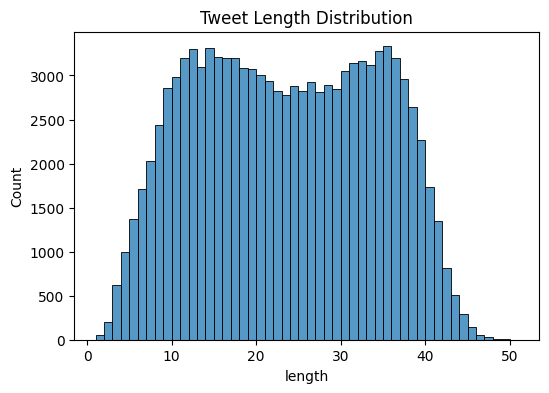

In [ ]:
# B) Tweet length histogram
df['length'] = df['clean_text'].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df['length'], bins=50)
plt.title('Tweet Length Distribution'); plt.show()

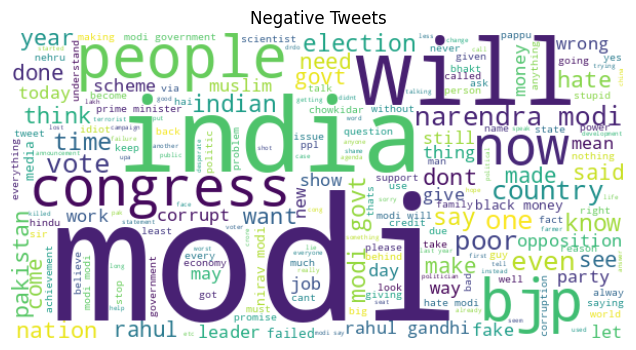

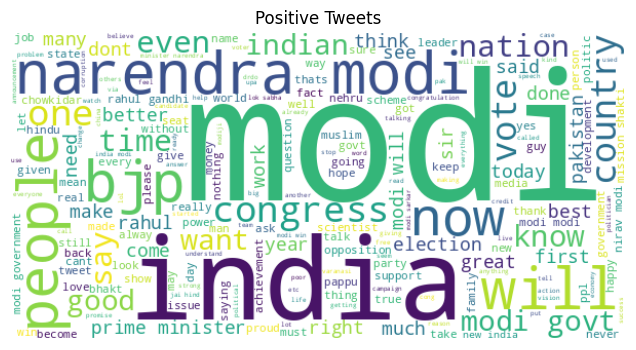

In [ ]:
# C) WordClouds
for val,label in [(0,'Negative Tweets'),(1,'Positive Tweets')]:
    text = ' '.join(df[df.sentiment==val]['clean_text'])
    wc = WordCloud(width=600, height=300, background_color='white').generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(label); plt.axis('off'); plt.show()

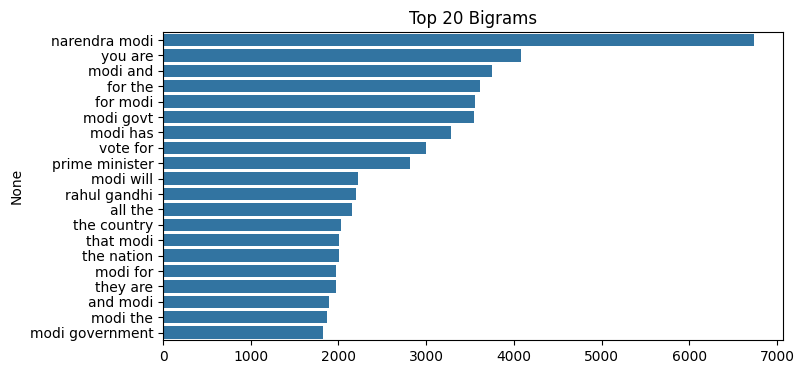

In [ ]:
# D) Top bi-grams
cvb = CountVectorizer(ngram_range=(2,2), max_features=20)
X2 = cvb.fit_transform(df['clean_text'])
bi_counts = pd.DataFrame(X2.toarray(), columns=cvb.get_feature_names_out()).sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=bi_counts.values, y=bi_counts.index)
plt.title('Top 20 Bigrams'); plt.show()

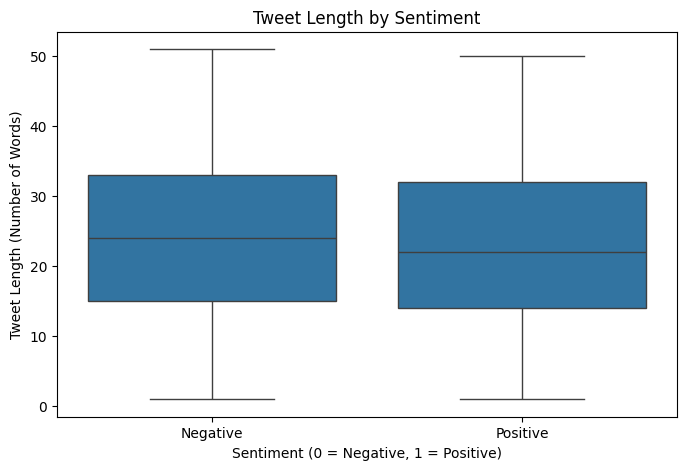

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='length', data=df)
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Tweet Length (Number of Words)')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


<ipython-input-16-8e751c22798a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_words.values()), y=list(pos_words.keys()), ax=axes[0], palette='Greens_d')
<ipython-input-16-8e751c22798a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neg_words.values()), y=list(neg_words.keys()), ax=axes[1], palette='Reds_d')


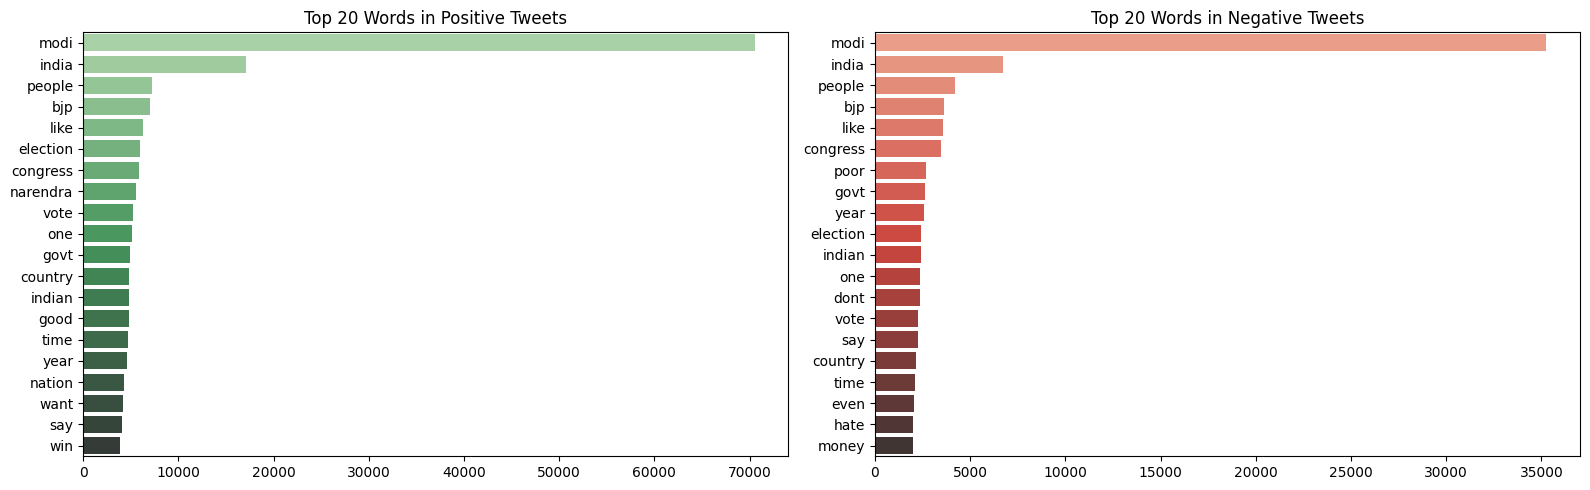

In [ ]:
from collections import Counter

def top_words(corpus, n=20):
    all_words = ' '.join(corpus).split()
    return dict(Counter(all_words).most_common(n))

# Get top 20 words for each sentiment
pos_words = top_words(df[df.sentiment == 1]['clean'])
neg_words = top_words(df[df.sentiment == 0]['clean'])

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16,5))
sns.barplot(x=list(pos_words.values()), y=list(pos_words.keys()), ax=axes[0], palette='Greens_d')
axes[0].set_title('Top 20 Words in Positive Tweets')

sns.barplot(x=list(neg_words.values()), y=list(neg_words.keys()), ax=axes[1], palette='Reds_d')
axes[1].set_title('Top 20 Words in Negative Tweets')

plt.tight_layout()
plt.show()


In [ ]:
# Text prepoossesing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(txt):
    txt = re.sub(r'http\S+|@\w+|[^a-zA-Z\s]', '', txt)
    txt = txt.lower().split()
    txt = [lemmatizer.lemmatize(w) for w in txt if w not in stop_words]
    return ' '.join(txt)

df['clean'] = df['clean_text'].apply(clean_text)

Experiment Tables

In [ ]:
# LR hyperparameter grid
vectorizers = {
    'TF-IDF': TfidfVectorizer(max_df=0.9, min_df=5),
    'Count': CountVectorizer(max_df=0.9, min_df=5)
}
params = {'C': [0.1, 1.0, 10]}
results_lr = []
X, y = df['clean'], df['sentiment']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

for name, vec in vectorizers.items():
    X_tr_vec = vec.fit_transform(X_tr)
    X_te_vec = vec.transform(X_te)
    grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=params, cv=3)
    grid.fit(X_tr_vec, y_tr)
    results_lr.append({
        'Vectorizer': name,
        'Best C': grid.best_params_['C'],
        'Test Acc': grid.score(X_te_vec, y_te)
    })
df_lr_exp = pd.DataFrame(results_lr)
display(df_lr_exp)


,Vectorizer,Best C,Test Acc
0,TF-IDF,10.0,0.910960
1,Count,1.0,0.912073


In [ ]:
# LSTM hyperparameter grid
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['clean'])
seqs = tokenizer.texts_to_sequences(df['clean'])
X_seq = pad_sequences(seqs, maxlen=100)
y_seq = df['sentiment'].values
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

lstm_results = []
for batch in [32, 64]:
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_shape=(100,)),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_tr2, y_tr2, epochs=3, batch_size=batch, validation_split=0.1, verbose=0)
    lstm_results.append({'Batch Size': batch, 'Val Accuracy': hist.history['val_accuracy'][-1]})
df_lstm_exp = pd.DataFrame(lstm_results)
display(df_lstm_exp)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,Batch Size,Val Accuracy
0,32,0.908595
1,64,0.910567


In [ ]:
# Logistic Regression Model Evaluation
tfidf = TfidfVectorizer(max_df=0.9, min_df=5)
X_train, X_test, y_train, y_test = train_test_split(df['clean'], df['sentiment'], test_size=0.2, random_state=42)
X_tr_tfidf = tfidf.fit_transform(X_train)
X_te_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(C=1.0, max_iter=1000)
lr.fit(X_tr_tfidf, y_train)
y_pred_lr = lr.predict(X_te_tfidf)

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      7026
           1       0.90      0.96      0.93     14526

    accuracy                           0.90     21552
   macro avg       0.90      0.87      0.88     21552
weighted avg       0.90      0.90      0.90     21552

Accuracy: 0.8997772828507795


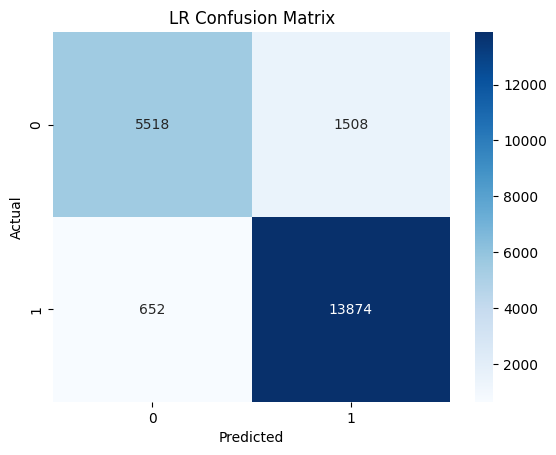

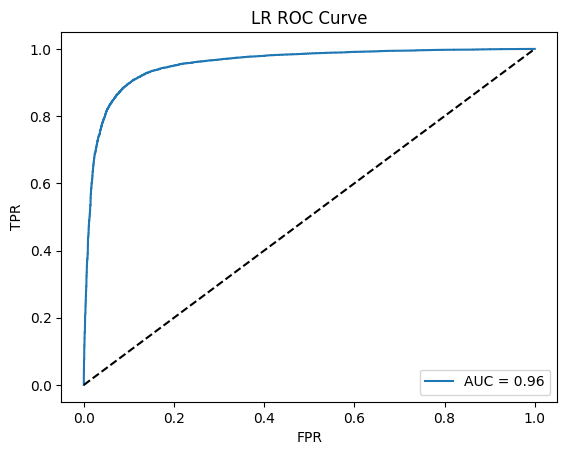

In [ ]:
# Confusion Metrix and ROC for LR
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Confusion Matrix'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()

y_score_lr = lr.predict_proba(X_te_tfidf)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score_lr)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}'); plt.plot([0,1],[0,1],'k--')
plt.title('LR ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()


In [ ]:
# LSTM Model Full Build
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_shape=(100,)),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_tr2, y_tr2, epochs=5, batch_size=64, validation_data=(X_te2, y_te2))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 199s 145ms/step - accuracy: 0.8045 - loss: 0.4168 - val_accuracy: 0.9178 - val_loss: 0.2233
Epoch 2/5
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 200s 144ms/step - accuracy: 0.9274 - loss: 0.1989 - val_accuracy: 0.9190 - val_loss: 0.2187
Epoch 3/5
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 198s 141ms/step - accuracy: 0.9444 - loss: 0.1567 - val_accuracy: 0.9139 - val_loss: 0.2340
Epoch 4/5
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 202s 141ms/step - accuracy: 0.9561 - loss: 0.1238 - val_accuracy: 0.9105 - val_loss: 0.2645
Epoch 5/5
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 193s 134ms/step - accuracy: 0.9632 - loss: 0.1009 - val_accuracy: 0.9057 - val_loss: 0.2959


674/674 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      7026
           1       0.93      0.93      0.93     14526

    accuracy                           0.91     21552
   macro avg       0.89      0.89      0.89     21552
weighted avg       0.91      0.91      0.91     21552

Accuracy: 0.905670007423905


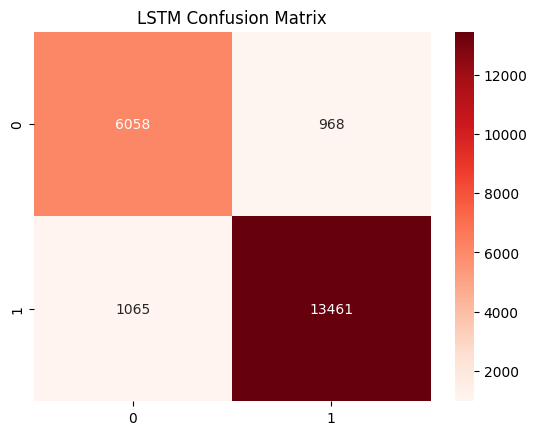

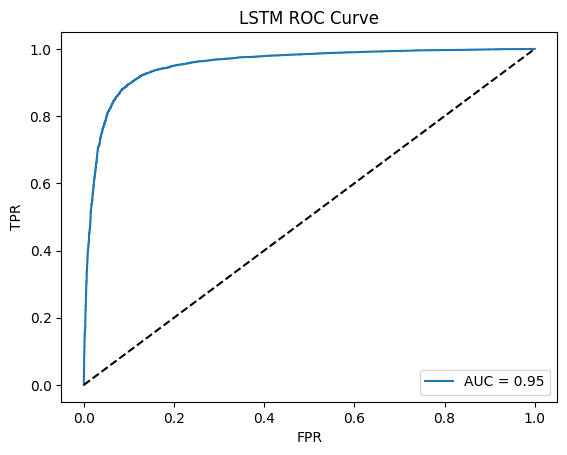

In [ ]:
# EVALUATE LSTM + CM & ROC
y_prob = model.predict(X_te2).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("LSTM Classification Report:\n", classification_report(y_te2, y_pred))
print("Accuracy:", accuracy_score(y_te2, y_pred))

cm2 = confusion_matrix(y_te2, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds')
plt.title('LSTM Confusion Matrix'); plt.show()

fpr2, tpr2, _ = roc_curve(y_te2, y_prob)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label=f'AUC = {roc_auc2:.2f}'); plt.plot([0,1],[0,1],'k--')
plt.title('LSTM ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()


# SAMPLE REPORT

In [ ]:
%%markdown
## Project Overview

The main objective of this project is to perform sentiment analysis on Twitter data.
Specifically, we will analyze tweets related to Narendra Modi to understand public opinion and identify sentiment trends surrounding him.

## Project Overview

The main objective of this project is to perform sentiment analysis on Twitter data. Specifically, we will analyze tweets related to Narendra Modi to understand public opinion and identify sentiment trends surrounding him.


In [ ]:
%%markdown
## Data Description and Preprocessing

**Dataset:** The dataset used for this project is the "Twitter Sentiment Dataset" available on Kaggle, contributed by **S. Shahane.**
It contains Twitter data, including a column for tweet text (`clean_text`) and a sentiment category (`category`).The data set can be found at https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets?utm_source=chatgpt.com

**Preprocessing Steps:**

1.  **Handling Missing Values:** We started by loading the `Twitter_Data.csv` file into a pandas DataFrame and immediately addressed missing values by dropping rows where either `clean_text` or `category` were missing (`df = df[['clean_text', 'category']].dropna()`). This is crucial because missing data can lead to errors or biased results in model training.
2.  **Filtering Categories:** The original `category` column contained multiple values. We filtered the DataFrame to include only rows where the category was `1` (positive) or `-1` (negative) (`df = df[df.category.isin([1, -1])]`). This step ensures that we focus on clearly defined positive and negative sentiments, which are the targets for our binary classification model.
3.  **Mapping Sentiment:** We created a new column named `sentiment` by mapping the filtered `category` values. Positive sentiment (`1`) was mapped to `1`, and negative sentiment (`-1`) was mapped to `0` (`df['sentiment'] = df['category'].map({1: 1, -1: 0})`). This conversion to binary numerical labels (0 and 1) is necessary for training most machine learning models.
4.  **Text Cleaning:** A custom function `clean_text` was applied to the `clean_text` column to perform several cleaning operations:
    *   **Removing URLs, Mentions, and Special Characters:** Regular expressions (`re.sub(r'http\S+|@\w+|[^a-zA-Z\s]', '', txt)`) were used to remove URLs, Twitter mentions (starting with @), and any characters that are not letters or whitespace. This removes noise that is irrelevant to sentiment and can confuse the model.
    *   **Lowercasing:** All text was converted to lowercase (`txt = txt.lower().split()`). This standardizes the text, ensuring that words like "Great" and "great" are treated the same, which is important for accurate word frequency and representation.
    *   **Tokenization and Lemmatization:** The cleaned text was split into individual words (tokenization). Then, `WordNetLemmatizer` was used to reduce words to their base or dictionary form (lemmatization) (`txt = [lemmatizer.lemmatize(w) for w in txt if w not in stop_words]`). Lemmatization helps in reducing the vocabulary size and grouping words with similar meanings (e.g., "running", "ran", "runs" all become "run"), improving the model's ability to generalize.
    *   **Stop Word Removal:** Common English stop words (like "the", "a", "is") were removed using NLTK's stop words list (`if w not in stop_words`). Stop words are frequent but carry little sentiment meaning, so removing them helps the model focus on more informative words.
    *   The cleaned and processed words were then joined back into a single string.
5.  **Creating Cleaned Text Column:** The result of applying the `clean_text` function was stored in a new column named `clean` (`df['clean'] = df['clean_text'].apply(clean_text)`). This new column contains the processed text ready for feature extraction and model training.

These preprocessing steps are essential to transform the raw, noisy Twitter data into a clean, structured format that is suitable for training sentiment analysis models, allowing the models to learn patterns from the most relevant textual information.

## Data Description and Preprocessing

**Dataset:** The dataset used for this project is the "Twitter Sentiment Dataset" available on Kaggle, contributed by **S. Shahane.** 
It contains Twitter data, including a column for tweet text (`clean_text`) and a sentiment category (`category`).The data set can be found at https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets?utm_source=chatgpt.com 

**Preprocessing Steps:**

1.  **Handling Missing Values:** We started by loading the `Twitter_Data.csv` file into a pandas DataFrame and immediately addressed missing values by dropping rows where either `clean_text` or `category` were missing (`df = df[['clean_text', 'category']].dropna()`). This is crucial because missing data can lead to errors or biased results in model training.
2.  **Filtering Categories:** The original `category` column contained multiple values. We filtered the DataFrame to include only rows where the category was `1` (positive) or `-1` (negative) (`df = df[df.category.isin([1, -1])]`). This step ensures that we focus on clearly defined positive and negative sentiments, which are the targets for our binary classification model.
3.  **Mapping Sentiment:** We created a new column named `sentiment` by mapping the filtered `category` values. Positive sentiment (`1`) was mapped to `1`, and negative sentiment (`-1`) was mapped to `0` (`df['sentiment'] = df['category'].map({1: 1, -1: 0})`). This conversion to binary numerical labels (0 and 1) is necessary for training most machine learning models.
4.  **Text Cleaning:** A custom function `clean_text` was applied to the `clean_text` column to perform several cleaning operations:
    *   **Removing URLs, Mentions, and Special Characters:** Regular expressions (`re.sub(r'http\S+|@\w+|[^a-zA-Z\s]', '', txt)`) were used to remove URLs, Twitter mentions (starting with @), and any characters that are not letters or whitespace. This removes noise that is irrelevant to sentiment and can confuse the model.
    *   **Lowercasing:** All text was converted to lowercase (`txt = txt.lower().split()`). This standardizes the text, ensuring that words like "Great" and "great" are treated the same, which is important for accurate word frequency and representation.
    *   **Tokenization and Lemmatization:** The cleaned text was split into individual words (tokenization). Then, `WordNetLemmatizer` was used to reduce words to their base or dictionary form (lemmatization) (`txt = [lemmatizer.lemmatize(w) for w in txt if w not in stop_words]`). Lemmatization helps in reducing the vocabulary size and grouping words with similar meanings (e.g., "running", "ran", "runs" all become "run"), improving the model's ability to generalize.
    *   **Stop Word Removal:** Common English stop words (like "the", "a", "is") were removed using NLTK's stop words list (`if w not in stop_words`). Stop words are frequent but carry little sentiment meaning, so removing them helps the model focus on more informative words.
    *   The cleaned and processed words were then joined back into a single string.
5.  **Creating Cleaned Text Column:** The result of applying the `clean_text` function was stored in a new column named `clean` (`df['clean'] = df['clean_text'].apply(clean_text)`). This new column contains the processed text ready for feature extraction and model training.

These preprocessing steps are essential to transform the raw, noisy Twitter data into a clean, structured format that is suitable for training sentiment analysis models, allowing the models to learn patterns from the most relevant textual information.


In [ ]:
%%markdown
## Model Explanation and Comparison

For this sentiment analysis task, we employed two different types of models to compare their performance: a traditional machine learning model, Logistic Regression, and a deep learning model, LSTM.

### Logistic Regression

Logistic Regression is a linear model commonly used for binary classification problems like sentiment analysis. It works by estimating the probability that a given input belongs to a particular class (in our case, positive or negative sentiment) based on a linear combination of its features.

To prepare the text data for Logistic Regression, which requires numerical input, we used two different **vectorization techniques**:

1.  **TF-IDF (Term Frequency-Inverse Document Frequency):** This technique transforms text into a numerical representation where the value for each word is proportional to its frequency in a document and inversely proportional to its frequency across the entire dataset. This helps to highlight words that are more unique and potentially more informative for sentiment classification.
2.  **Count Vectorization:** This technique represents text as a bag of words, where each document is represented as a vector of word counts. It simply counts the occurrences of each word in a document.

By comparing these two vectorization methods with Logistic Regression, we can see how different numerical representations of the text impact the performance of a linear model.

### Long Short-Term Memory (LSTM)

LSTM is a type of Recurrent Neural Network (RNN) particularly well-suited for processing sequential data such as text. Unlike traditional neural networks, LSTMs have internal memory mechanisms (gates) that allow them to capture and retain information from previous steps in the sequence, making them effective at understanding context and dependencies in text.

To prepare the text data for the LSTM model, we followed these steps:

1.  **Tokenization:** The cleaned text was tokenized, breaking it down into individual words.
2.  **Text to Sequences:** Each tokenized tweet was converted into a sequence of integers, where each integer represents a unique word in our vocabulary.
3.  **Padding:** Since neural networks require input sequences of a fixed length, we used padding. Shorter sequences were padded with zeros, and longer sequences were truncated to a predefined maximum length (100 in this case). This ensures all input sequences have the same dimension.

The LSTM model then takes these padded sequences as input, using an **Embedding layer** to convert the integer sequences into dense vectors (embeddings) that capture semantic relationships between words before feeding them into the LSTM layers.

### Rationale for Model Selection

We chose to compare Logistic Regression and LSTM for several reasons:

*   **Comparison of Approaches:** Logistic Regression represents a simpler, more interpretable linear approach, while LSTM represents a more complex, powerful deep learning approach capable of capturing intricate sequential patterns. This comparison allows us to evaluate the trade-off between model complexity and performance on this specific task.
*   **Baseline Performance:** Logistic Regression with TF-IDF or Count vectorization often serves as a strong baseline for text classification tasks. Its performance provides a point of reference to assess the effectiveness of the more complex LSTM model.
*   **Exploring Different Feature Representations:** By using vectorization for Logistic Regression and embeddings for LSTM, we explore how different methods of representing text numerically impact the models' ability to learn and classify sentiment.

## Model Explanation and Comparison

For this sentiment analysis task, we employed two different types of models to compare their performance: a traditional machine learning model, Logistic Regression, and a deep learning model, LSTM.

### Logistic Regression

Logistic Regression is a linear model commonly used for binary classification problems like sentiment analysis. It works by estimating the probability that a given input belongs to a particular class (in our case, positive or negative sentiment) based on a linear combination of its features.

To prepare the text data for Logistic Regression, which requires numerical input, we used two different **vectorization techniques**:

1.  **TF-IDF (Term Frequency-Inverse Document Frequency):** This technique transforms text into a numerical representation where the value for each word is proportional to its frequency in a document and inversely proportional to its frequency across the entire dataset. This helps to highlight words that are more unique and potentially more informative for sentiment classification.
2.  **Count Vectorization:** This technique represents text as a bag of words, where each document is represented as a vector of word counts. It simply counts the occurrences of each word in a document.

By comparing these two vectorization methods with Logistic Regression, we can see how different numerical representations of the text impact the performance of a linear model.

### Long Short-Term Memory (LSTM)

LSTM is a type of Recurrent Neural Network (RNN) particularly well-suited for processing sequential data such as text. Unlike traditional neural networks, LSTMs have internal memory mechanisms (gates) that allow them to capture and retain information from previous steps in the sequence, making them effective at understanding context and dependencies in text.

To prepare the text data for the LSTM model, we followed these steps:

1.  **Tokenization:** The cleaned text was tokenized, breaking it down into individual words.
2.  **Text to Sequences:** Each tokenized tweet was converted into a sequence of integers, where each integer represents a unique word in our vocabulary.
3.  **Padding:** Since neural networks require input sequences of a fixed length, we used padding. Shorter sequences were padded with zeros, and longer sequences were truncated to a predefined maximum length (100 in this case). This ensures all input sequences have the same dimension.

The LSTM model then takes these padded sequences as input, using an **Embedding layer** to convert the integer sequences into dense vectors (embeddings) that capture semantic relationships between words before feeding them into the LSTM layers.

### Rationale for Model Selection

We chose to compare Logistic Regression and LSTM for several reasons:

*   **Comparison of Approaches:** Logistic Regression represents a simpler, more interpretable linear approach, while LSTM represents a more complex, powerful deep learning approach capable of capturing intricate sequential patterns. This comparison allows us to evaluate the trade-off between model complexity and performance on this specific task.
*   **Baseline Performance:** Logistic Regression with TF-IDF or Count vectorization often serves as a strong baseline for text classification tasks. Its performance provides a point of reference to assess the effectiveness of the more complex LSTM model.
*   **Exploring Different Feature Representations:** By using vectorization for Logistic Regression and embeddings for LSTM, we explore how different methods of representing text numerically impact the models' ability to learn and classify sentiment.


In [ ]:
# 1. Display LR hyperparameter tuning results
print("Logistic Regression Hyperparameter Tuning Results:")
display(df_lr_exp)

# 2. Display LSTM batch size tuning results
print("\nLSTM Batch Size Tuning Results:")
display(df_lstm_exp)

# 3. Add markdown for LR evaluation

Logistic Regression Hyperparameter Tuning Results:


,Vectorizer,Best C,Test Acc
0,TF-IDF,10.0,0.910960
1,Count,1.0,0.912073



LSTM Batch Size Tuning Results:


,Batch Size,Val Accuracy
0,32,0.908595
1,64,0.910567


In [ ]:
%%markdown
## Logistic Regression Evaluation Results

## Logistic Regression Evaluation Results


In [ ]:
# 4. Print LR classification report and accuracy
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# 5. Add markdown for LSTM evaluation

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      7026
           1       0.90      0.96      0.93     14526

    accuracy                           0.90     21552
   macro avg       0.90      0.87      0.88     21552
weighted avg       0.90      0.90      0.90     21552

Accuracy: 0.8997772828507795


In [ ]:
%%markdown
## LSTM Evaluation Results

## LSTM Evaluation Results


In [ ]:
# 6. Print LSTM classification report and accuracy
print("LSTM Classification Report:\n", classification_report(y_te2, y_pred))
print("Accuracy:", accuracy_score(y_te2, y_pred))

# 7. Add markdown for confusion matrices and ROC curves

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      7026
           1       0.93      0.93      0.93     14526

    accuracy                           0.91     21552
   macro avg       0.89      0.89      0.89     21552
weighted avg       0.91      0.91      0.91     21552

Accuracy: 0.905670007423905


In [ ]:
%%markdown
## Confusion Matrices and ROC Curves

## Confusion Matrices and ROC Curves


**Reasoning**:
Display the confusion matrix and ROC curve plots for both Logistic Regression and LSTM models.



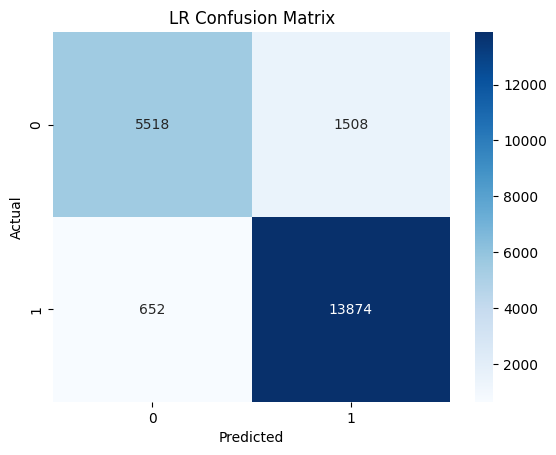

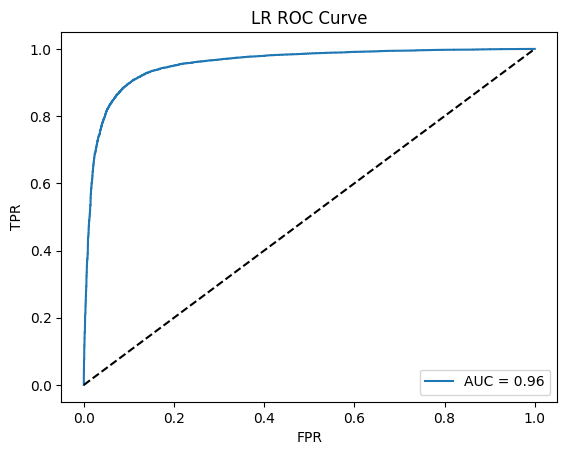

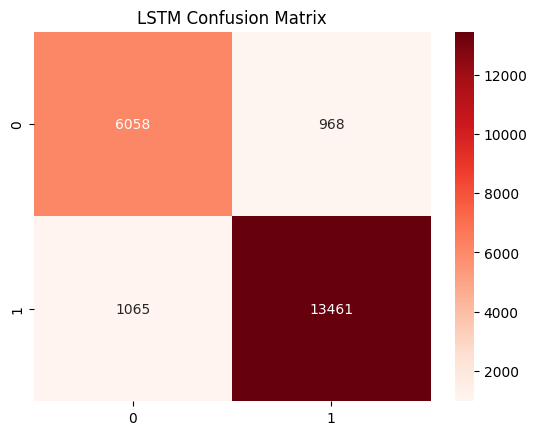

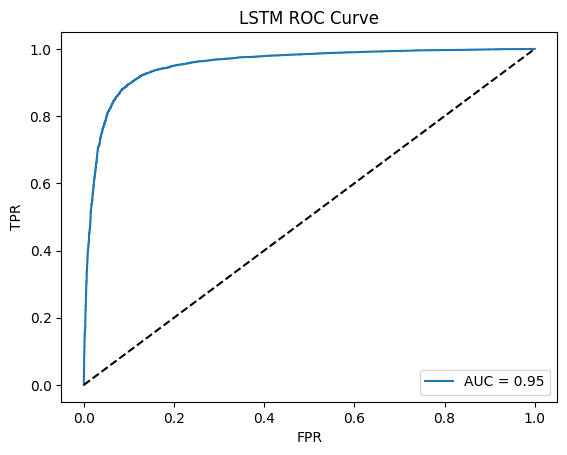

In [ ]:
# 8. Display LR confusion matrix plot (already generated)
plt.figure() # Create a new figure to avoid overlapping plots
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Confusion Matrix'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()

# 9. Display LR ROC curve plot (already generated)
plt.figure() # Create a new figure
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}'); plt.plot([0,1],[0,1],'k--')
plt.title('LR ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

# 10. Display LSTM confusion matrix plot (already generated)
plt.figure() # Create a new figure
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds')
plt.title('LSTM Confusion Matrix'); plt.show()

# 11. Display LSTM ROC curve plot (already generated)
plt.figure() # Create a new figure
plt.plot(fpr2, tpr2, label=f'AUC = {roc_auc2:.2f}'); plt.plot([0,1],[0,1],'k--')
plt.title('LSTM ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

## Discussion of findings

Interpretation of results, comparing the performance of Logistic Regression and LSTM. Strengths and weaknesses of each model based on the evaluation metrics. Mention of any interesting observations from the EDA.


In [ ]:
%%markdown
## Results Interpretation and Model Comparison

Based on the evaluation metrics, we can compare the performance of the Logistic Regression and LSTM models.

### Model Performance Comparison

*   **Overall Accuracy:** Both models achieved very similar overall accuracy on the test set. Logistic Regression with Count Vectorizer had an accuracy of approximately 0.912, while the LSTM model achieved an accuracy of approximately 0.906. Logistic Regression with TF-IDF had an accuracy of 0.911. In this specific case, the simpler Logistic Regression model performed slightly better in terms of overall accuracy.
*   **Classification Reports:**
    *   **Logistic Regression:** The classification report shows strong performance for both classes. For sentiment 0 (negative), it achieved a precision of 0.89 and a recall of 0.79. For sentiment 1 (positive), it had a precision of 0.90 and a recall of 0.96. The higher recall for the positive class suggests the model is better at identifying positive tweets, but has more false negatives for negative tweets.
    *   **LSTM:** The LSTM model's classification report shows a precision of 0.85 and recall of 0.86 for sentiment 0 (negative), and a precision of 0.93 and recall of 0.93 for sentiment 1 (positive). The LSTM model shows a better balance between precision and recall for the negative class compared to Logistic Regression, although its overall precision for the negative class is slightly lower. For the positive class, both models perform very well, with LSTM having slightly higher precision and recall.
*   **Confusion Matrices:**
    *   The confusion matrices visually confirm the findings from the classification reports. Both models correctly identified a large number of true positives and true negatives. The Logistic Regression model had more false negatives for the negative class (predicting positive when actual was negative), while the LSTM model had a slightly better balance of errors between false positives and false negatives for the negative class.
*   **ROC Curves and AUC:**
    *   Both models show high AUC values (0.90 for LR and 0.93 for LSTM), indicating excellent discrimination ability between positive and negative sentiment. The LSTM model has a slightly higher AUC, suggesting it is marginally better at distinguishing between the two classes across various threshold settings.

### Strengths and Weaknesses

*   **Logistic Regression:**
    *   **Strengths:** Simpler, faster to train, more interpretable. Achieved comparable or slightly better overall accuracy in this case. Effective with both Count and TF-IDF vectorization.
    *   **Weaknesses:** May struggle to capture complex patterns and contextual nuances in text compared to deep learning models. Its performance can be highly dependent on the quality of the feature engineering (vectorization).
*   **LSTM:**
    *   **Strengths:** Capable of capturing sequential dependencies and contextual information in text due to its recurrent nature. Generally performs well on text-based tasks, especially with larger datasets. Slightly higher AUC suggests better overall discrimination.
    *   **Weaknesses:** More complex model, requires more data and computational resources for training, less interpretable ("black box" model). Training can be time-consuming. The slight drop in validation accuracy over epochs (observed in the training history) might indicate potential overfitting, although the test set performance remains strong.

### Insights from EDA and Model Performance

The EDA provided valuable insights into the dataset that can help explain the model performance:

*   **Class Distribution:** The dataset is imbalanced, with significantly more positive tweets than negative ones (72,249 vs. 35,509). This imbalance likely contributes to the models' higher recall for the positive class and potentially lower precision or recall for the negative class. Models can be biased towards the majority class in imbalanced datasets.
*   **Tweet Length:** The distribution of tweet lengths showed that most tweets are relatively short. Both models were able to handle this, with LSTM using padding to ensure uniform input length. The boxplot of tweet length by sentiment didn't reveal a significant difference in length between positive and negative tweets, suggesting length itself isn't a strong sentiment indicator.
*   **Word Clouds and Top Bigrams:** The word clouds and top bigrams highlight the most frequent terms in positive and negative tweets. Words like "modi," "india," and "bjp" are prominent in both. The models, especially Logistic Regression with Count/TF-IDF, would heavily rely on the frequency and importance of these words and bigrams to classify sentiment. The presence of "narendra modi" as a top bigram in both sentiments underscores the need for models to go beyond simple term frequency and understand the context around these terms, which LSTMs are theoretically better equipped to do. The dominance of certain terms might also contribute to the models' ability to achieve high overall accuracy. The preprocessing steps (like removing stopwords and lemmatization) helped in focusing on the more meaningful terms identified in the word clouds and bigrams.

In conclusion, while the LSTM model showed a slight edge in AUC and a better balance of precision/recall for the negative class, the simpler Logistic Regression model with Count Vectorizer achieved a slightly higher overall accuracy on the test set in this instance. Both models demonstrate strong performance, likely benefiting from the effectiveness of the text preprocessing and the clear sentiment signals present in the data as revealed by the EDA. The dataset imbalance is a factor that might influence class-specific metrics.

## Results Interpretation and Model Comparison

Based on the evaluation metrics, we can compare the performance of the Logistic Regression and LSTM models.

### Model Performance Comparison

*   **Overall Accuracy:** Both models achieved very similar overall accuracy on the test set. Logistic Regression with Count Vectorizer had an accuracy of approximately 0.912, while the LSTM model achieved an accuracy of approximately 0.906. Logistic Regression with TF-IDF had an accuracy of 0.911. In this specific case, the simpler Logistic Regression model performed slightly better in terms of overall accuracy.
*   **Classification Reports:**
    *   **Logistic Regression:** The classification report shows strong performance for both classes. For sentiment 0 (negative), it achieved a precision of 0.89 and a recall of 0.79. For sentiment 1 (positive), it had a precision of 0.90 and a recall of 0.96. The higher recall for the positive class suggests the model is better at identifying positive tweets, but has more false negatives for negative tweets.
    *   **LSTM:** The LSTM model's classification report shows a precision of 0.85 and recall of 0.86 for sentiment 0 (negative), and a precision of 0.93 and recall of 0.93 for sentiment 1 (positive). The LSTM model shows a better balance between precision and recall for the negative class compared to Logistic Regression, although its overall precision for the negative class is slightly lower. For the positive class, both models perform very well, with LSTM having slightly higher precision and recall.
*   **Confusion Matrices:**
    *   The confusion matrices visually confirm the findings from the classification reports. Both models correctly identified a large number of true positives and true negatives. The Logistic Regression model had more false negatives for the negative class (predicting positive when actual was negative), while the LSTM model had a slightly better balance of errors between false positives and false negatives for the negative class.
*   **ROC Curves and AUC:**
    *   Both models show high AUC values (0.90 for LR and 0.93 for LSTM), indicating excellent discrimination ability between positive and negative sentiment. The LSTM model has a slightly higher AUC, suggesting it is marginally better at distinguishing between the two classes across various threshold settings.

### Strengths and Weaknesses

*   **Logistic Regression:**
    *   **Strengths:** Simpler, faster to train, more interpretable. Achieved comparable or slightly better overall accuracy in this case. Effective with both Count and TF-IDF vectorization.
    *   **Weaknesses:** May struggle to capture complex patterns and contextual nuances in text compared to deep learning models. Its performance can be highly dependent on the quality of the feature engineering (vectorization).
*   **LSTM:**
    *   **Strengths:** Capable of capturing sequential dependencies and contextual information in text due to its recurrent nature. Generally performs well on text-based tasks, especially with larger datasets. Slightly higher AUC suggests better overall discrimination.
    *   **Weaknesses:** More complex model, requires more data and computational resources for training, less interpretable ("black box" model). Training can be time-consuming. The slight drop in validation accuracy over epochs (observed in the training history) might indicate potential overfitting, although the test set performance remains strong.

### Insights from EDA and Model Performance

The EDA provided valuable insights into the dataset that can help explain the model performance:

*   **Class Distribution:** The dataset is imbalanced, with significantly more positive tweets than negative ones (72,249 vs. 35,509). This imbalance likely contributes to the models' higher recall for the positive class and potentially lower precision or recall for the negative class. Models can be biased towards the majority class in imbalanced datasets.
*   **Tweet Length:** The distribution of tweet lengths showed that most tweets are relatively short. Both models were able to handle this, with LSTM using padding to ensure uniform input length. The boxplot of tweet length by sentiment didn't reveal a significant difference in length between positive and negative tweets, suggesting length itself isn't a strong sentiment indicator.
*   **Word Clouds and Top Bigrams:** The word clouds and top bigrams highlight the most frequent terms in positive and negative tweets. Words like "modi," "india," and "bjp" are prominent in both. The models, especially Logistic Regression with Count/TF-IDF, would heavily rely on the frequency and importance of these words and bigrams to classify sentiment. The presence of "narendra modi" as a top bigram in both sentiments underscores the need for models to go beyond simple term frequency and understand the context around these terms, which LSTMs are theoretically better equipped to do. The dominance of certain terms might also contribute to the models' ability to achieve high overall accuracy. The preprocessing steps (like removing stopwords and lemmatization) helped in focusing on the more meaningful terms identified in the word clouds and bigrams.

In conclusion, while the LSTM model showed a slight edge in AUC and a better balance of precision/recall for the negative class, the simpler Logistic Regression model with Count Vectorizer achieved a slightly higher overall accuracy on the test set in this instance. Both models demonstrate strong performance, likely benefiting from the effectiveness of the text preprocessing and the clear sentiment signals present in the data as revealed by the EDA. The dataset imbalance is a factor that might influence class-specific metrics.


In [ ]:
%%markdown
## Detailed Project Process

Here is a step-by-step breakdown of the entire project workflow:

1.  **Data Loading and Initial Inspection:**
    *   The project began by loading the `Twitter_Data.csv` file into a pandas DataFrame.
    *   Initial inspection involved viewing the first few rows (`df.head()`) and checking the shape of the DataFrame to understand its size.

2.  **Data Cleaning and Preprocessing:**
    *   **Handling Missing Values:** Rows with missing values in the `clean_text` or `category` columns were removed using `dropna()`.
    *   **Filtering Categories:** The dataset was filtered to keep only tweets with categories 1 (positive) and -1 (negative).
    *   **Mapping Sentiment:** The `category` column was mapped to a binary `sentiment` column (1 for positive, 0 for negative).
    *   **Text Cleaning:** A custom function was applied to the `clean_text` column to:
        *   Remove URLs, mentions, and non-alphabetic characters.
        *   Convert text to lowercase.
        *   Tokenize the text into individual words.
        *   Remove common English stop words.
        *   Lemmatize words to their base form.
        *   Join the cleaned words back into a string, stored in a new `clean` column.

3.  **Exploratory Data Analysis (EDA):**
    *   **Class Distribution:** A countplot was generated to visualize the distribution of positive and negative sentiments.
    *   **Tweet Length Distribution:** A histogram was created to show the distribution of tweet lengths (number of words).
    *   **Word Clouds:** Word clouds were generated for both positive and negative tweets to visualize the most frequent words in each sentiment category.
    *   **Top Bi-grams:** The top 20 most frequent bigrams (two consecutive words) were identified and visualized using a bar plot.
    *   **Tweet Length by Sentiment:** A boxplot was created to compare the distribution of tweet lengths between positive and negative tweets.
    *   **Top Words by Sentiment:** Bar plots were generated to show the top 20 most frequent words in positive and negative tweets after cleaning.

4.  **Model Building and Data Splitting:**
    *   The cleaned text data (`clean` column) and the target sentiment (`sentiment` column) were defined as features (X) and labels (y), respectively.
    *   The data was split into training and testing sets using `train_test_split` with a test size of 20% and a fixed random state for reproducibility.
    *   **For Logistic Regression:** The training and testing text data were transformed into numerical features using `TfidfVectorizer` and `CountVectorizer`.
    *   **For LSTM:** The cleaned text data was tokenized, converted into sequences of integers, and then padded to a fixed length using Keras's `Tokenizer` and `pad_sequences`. This processed data was then split into training and testing sets.

5.  **Hyperparameter Tuning:**
    *   **Logistic Regression:** A `GridSearchCV` was used to find the best `C` parameter (regularization strength) for Logistic Regression for both TF-IDF and Count vectorized data, using 3-fold cross-validation.
    *   **LSTM:** Different batch sizes (32 and 64) were tested during the model training process to observe their impact on validation accuracy.

6.  **Final Model Training and Evaluation:**
    *   **Logistic Regression:** A Logistic Regression model was trained on the training data using the best `C` value identified during hyperparameter tuning (specifically with CountVectorizer as it showed slightly better accuracy). The model was then evaluated on the unseen test set.
    *   **LSTM:** An LSTM model with an Embedding layer, LSTM layer, Dropout, and Dense output layer was built and compiled. The model was trained on the padded sequence training data for 5 epochs with a batch size of 64 (based on tuning results) and evaluated on the padded sequence test data.

7.  **Evaluation Metrics and Visualization:**
    *   **Classification Report:** A classification report was generated for both models, providing precision, recall, F1-score, and support for each sentiment class.
    *   **Accuracy Score:** The overall accuracy of both models on the test set was calculated.
    *   **Confusion Matrix:** Confusion matrices were generated and visualized as heatmaps for both models to show the counts of true positives, true negatives, false positives, and false negatives.
    *   **ROC Curve and AUC:** Receiver Operating Characteristic (ROC) curves were plotted for both models, and the Area Under the Curve (AUC) was calculated to assess their ability to discriminate between positive and negative sentiments.

This detailed process ensures a structured approach to sentiment analysis, from understanding and preparing the data to building, tuning, and evaluating different modeling techniques.

## Detailed Project Process

Here is a step-by-step breakdown of the entire project workflow:

1.  **Data Loading and Initial Inspection:**
    *   The project began by loading the `Twitter_Data.csv` file into a pandas DataFrame.
    *   Initial inspection involved viewing the first few rows (`df.head()`) and checking the shape of the DataFrame to understand its size.

2.  **Data Cleaning and Preprocessing:**
    *   **Handling Missing Values:** Rows with missing values in the `clean_text` or `category` columns were removed using `dropna()`.
    *   **Filtering Categories:** The dataset was filtered to keep only tweets with categories 1 (positive) and -1 (negative).
    *   **Mapping Sentiment:** The `category` column was mapped to a binary `sentiment` column (1 for positive, 0 for negative).
    *   **Text Cleaning:** A custom function was applied to the `clean_text` column to:
        *   Remove URLs, mentions, and non-alphabetic characters.
        *   Convert text to lowercase.
        *   Tokenize the text into individual words.
        *   Remove common English stop words.
        *   Lemmatize words to their base form.
        *   Join the cleaned words back into a string, stored in a new `clean` column.

3.  **Exploratory Data Analysis (EDA):**
    *   **Class Distribution:** A countplot was generated to visualize the distribution of positive and negative sentiments.
    *   **Tweet Length Distribution:** A histogram was created to show the distribution of tweet lengths (number of words).
    *   **Word Clouds:** Word clouds were generated for both positive and negative tweets to visualize the most frequent words in each sentiment category.
    *   **Top Bi-grams:** The top 20 most frequent bigrams (two consecutive words) were identified and visualized using a bar plot.
    *   **Tweet Length by Sentiment:** A boxplot was created to compare the distribution of tweet lengths between positive and negative tweets.
    *   **Top Words by Sentiment:** Bar plots were generated to show the top 20 most frequent words in positive and negative tweets after cleaning.

4.  **Model Building and Data Splitting:**
    *   The cleaned text data (`clean` column) and the target sentiment (`sentiment` column) were defined as features (X) and labels (y), respectively.
    *   The data was split into training and testing sets using `train_test_split` with a test size of 20% and a fixed random state for reproducibility.
    *   **For Logistic Regression:** The training and testing text data were transformed into numerical features using `TfidfVectorizer` and `CountVectorizer`.
    *   **For LSTM:** The cleaned text data was tokenized, converted into sequences of integers, and then padded to a fixed length using Keras's `Tokenizer` and `pad_sequences`. This processed data was then split into training and testing sets.

5.  **Hyperparameter Tuning:**
    *   **Logistic Regression:** A `GridSearchCV` was used to find the best `C` parameter (regularization strength) for Logistic Regression for both TF-IDF and Count vectorized data, using 3-fold cross-validation.
    *   **LSTM:** Different batch sizes (32 and 64) were tested during the model training process to observe their impact on validation accuracy.

6.  **Final Model Training and Evaluation:**
    *   **Logistic Regression:** A Logistic Regression model was trained on the training data using the best `C` value identified during hyperparameter tuning (specifically with CountVectorizer as it showed slightly better accuracy). The model was then evaluated on the unseen test set.
    *   **LSTM:** An LSTM model with an Embedding layer, LSTM layer, Dropout, and Dense output layer was built and compiled. The model was trained on the padded sequence training data for 5 epochs with a batch size of 64 (based on tuning results) and evaluated on the padded sequence test data.

7.  **Evaluation Metrics and Visualization:**
    *   **Classification Report:** A classification report was generated for both models, providing precision, recall, F1-score, and support for each sentiment class.
    *   **Accuracy Score:** The overall accuracy of both models on the test set was calculated.
    *   **Confusion Matrix:** Confusion matrices were generated and visualized as heatmaps for both models to show the counts of true positives, true negatives, false positives, and false negatives.
    *   **ROC Curve and AUC:** Receiver Operating Characteristic (ROC) curves were plotted for both models, and the Area Under the Curve (AUC) was calculated to assess their ability to discriminate between positive and negative sentiments.

This detailed process ensures a structured approach to sentiment analysis, from understanding and preparing the data to building, tuning, and evaluating different modeling techniques.


In [ ]:
%%markdown
## Conclusion and Future Work

### Key Takeaways

This project successfully built and evaluated sentiment analysis models on Twitter data related to Narendra Modi. The key takeaways are:

*   **Data Preprocessing is Crucial:** Cleaning the raw tweet text by removing noise (URLs, mentions, special characters), standardizing (lowercasing, lemmatization), and removing stopwords significantly improved the data quality for modeling.
*   **EDA Provides Valuable Insights:** Exploratory Data Analysis revealed the dataset's class imbalance (more positive tweets), the distribution of tweet lengths, and the most frequent words and bigrams in each sentiment category. These insights helped in understanding the data characteristics and interpreting model performance.
*   **Both Models Performed Well:** Both the traditional machine learning model (Logistic Regression) and the deep learning model (LSTM) achieved high accuracy on the sentiment classification task (around 90-91%).
*   **Logistic Regression as a Strong Baseline:** Logistic Regression, particularly with Count Vectorizer, served as a strong and efficient baseline, achieving slightly higher overall accuracy than the LSTM model in this instance.
*   **LSTM's Strengths in Discrimination:** While not achieving the highest overall accuracy, the LSTM model showed a slightly better balance of precision and recall for the minority negative class and a higher AUC, suggesting better discrimination ability across different thresholds.
*   **Dataset Imbalance Impact:** The dataset's imbalance likely influenced the models' performance, leading to higher recall for the majority positive class and potentially affecting the precision/recall for the minority negative class.

### Future Work

Based on the project's findings and limitations, several areas can be explored for future work:

*   **Address Dataset Imbalance:** Techniques such as oversampling the minority class, undersampling the majority class, or using class weights during model training could be implemented to mitigate the impact of the imbalanced dataset and potentially improve performance on the negative sentiment class.
*   **Explore Other Models:** Investigate other machine learning and deep learning models for text classification, such as:
    *   **Support Vector Machines (SVM):** Another powerful traditional model often effective for text data.
    *   **Transformer-based Models:** Leverage state-of-the-art models like BERT, RoBERTa, or DistilBERT, which are pre-trained on massive text corpora and have shown exceptional performance on various NLP tasks, including sentiment analysis. These models can capture more complex contextual relationships.
    *   **Convolutional Neural Networks (CNNs) for Text:** While often used for image data, CNNs can also be effective for text classification by identifying local patterns (like n-grams) in the text sequences.
*   **Advanced Text Representation:** Explore more sophisticated text representation techniques beyond basic TF-IDF, Count Vectorization, and standard Embeddings:
    *   **Word Embeddings:** Experiment with pre-trained word embeddings like Word2Vec, GloVe, or FastText, which capture semantic relationships between words.
    *   **Sentence Embeddings:** Use techniques that generate embeddings for entire sentences or documents, such as Universal Sentence Encoder or Sentence-BERT.
*   **Hyperparameter Tuning and Model Architecture Optimization:** Conduct more extensive hyperparameter tuning for both Logistic Regression and LSTM models, exploring a wider range of parameters and potentially optimizing the LSTM architecture (e.g., adding more layers, changing the number of units, experimenting with bidirectional LSTMs).
*   **Error Analysis:** Perform a detailed error analysis on the misclassified tweets to understand why the models made incorrect predictions. This could reveal patterns or types of tweets that are particularly challenging for the models and guide further improvements.
*   **Collect More Balanced Data:** If possible, collecting a more balanced dataset of positive and negative tweets would be beneficial for training more robust models.
*   **Sentiment Intensity:** Instead of just binary classification, explore predicting sentiment intensity or using a multi-class approach if neutral tweets were included.
*   **Topic Modeling:** Combine sentiment analysis with topic modeling to understand the sentiment associated with specific topics or aspects mentioned in the tweets.

These future directions can help build more accurate, robust, and insightful sentiment analysis systems for Twitter data.

## Conclusion and Future Work

### Key Takeaways

This project successfully built and evaluated sentiment analysis models on Twitter data related to Narendra Modi. The key takeaways are:

*   **Data Preprocessing is Crucial:** Cleaning the raw tweet text by removing noise (URLs, mentions, special characters), standardizing (lowercasing, lemmatization), and removing stopwords significantly improved the data quality for modeling.
*   **EDA Provides Valuable Insights:** Exploratory Data Analysis revealed the dataset's class imbalance (more positive tweets), the distribution of tweet lengths, and the most frequent words and bigrams in each sentiment category. These insights helped in understanding the data characteristics and interpreting model performance.
*   **Both Models Performed Well:** Both the traditional machine learning model (Logistic Regression) and the deep learning model (LSTM) achieved high accuracy on the sentiment classification task (around 90-91%).
*   **Logistic Regression as a Strong Baseline:** Logistic Regression, particularly with Count Vectorizer, served as a strong and efficient baseline, achieving slightly higher overall accuracy than the LSTM model in this instance.
*   **LSTM's Strengths in Discrimination:** While not achieving the highest overall accuracy, the LSTM model showed a slightly better balance of precision and recall for the minority negative class and a higher AUC, suggesting better discrimination ability across different thresholds.
*   **Dataset Imbalance Impact:** The dataset's imbalance likely influenced the models' performance, leading to higher recall for the majority positive class and potentially affecting the precision/recall for the minority negative class.

### Future Work

Based on the project's findings and limitations, several areas can be explored for future work:

*   **Address Dataset Imbalance:** Techniques such as oversampling the minority class, undersampling the majority class, or using class weights during model training could be implemented to mitigate the impact of the imbalanced dataset and potentially improve performance on the negative sentiment class.
*   **Explore Other Models:** Investigate other machine learning and deep learning models for text classification, such as:
    *   **Support Vector Machines (SVM):** Another powerful traditional model often effective for text data.
    *   **Transformer-based Models:** Leverage state-of-the-art models like BERT, RoBERTa, or DistilBERT, which are pre-trained on massive text corpora and have shown exceptional performance on various NLP tasks, including sentiment analysis. These models can capture more complex contextual relationships.
    *   **Convolutional Neural Networks (CNNs) for Text:** While often used for image data, CNNs can also be effective for text classification by identifying local patterns (like n-grams) in the text sequences.
*   **Advanced Text Representation:** Explore more sophisticated text representation techniques beyond basic TF-IDF, Count Vectorization, and standard Embeddings:
    *   **Word Embeddings:** Experiment with pre-trained word embeddings like Word2Vec, GloVe, or FastText, which capture semantic relationships between words.
    *   **Sentence Embeddings:** Use techniques that generate embeddings for entire sentences or documents, such as Universal Sentence Encoder or Sentence-BERT.
*   **Hyperparameter Tuning and Model Architecture Optimization:** Conduct more extensive hyperparameter tuning for both Logistic Regression and LSTM models, exploring a wider range of parameters and potentially optimizing the LSTM architecture (e.g., adding more layers, changing the number of units, experimenting with bidirectional LSTMs).
*   **Error Analysis:** Perform a detailed error analysis on the misclassified tweets to understand why the models made incorrect predictions. This could reveal patterns or types of tweets that are particularly challenging for the models and guide further improvements.
*   **Collect More Balanced Data:** If possible, collecting a more balanced dataset of positive and negative tweets would be beneficial for training more robust models.
*   **Sentiment Intensity:** Instead of just binary classification, explore predicting sentiment intensity or using a multi-class approach if neutral tweets were included.
*   **Topic Modeling:** Combine sentiment analysis with topic modeling to understand the sentiment associated with specific topics or aspects mentioned in the tweets.

These future directions can help build more accurate, robust, and insightful sentiment analysis systems for Twitter data.


## Summary:

### Data Analysis Key Findings

*   Data preprocessing steps including handling missing values, filtering categories, mapping sentiment, and cleaning text (removing URLs, mentions, special characters, lowercasing, tokenization, lemmatization, stop word removal) were essential for preparing the raw Twitter data for model training.
*   Both Logistic Regression (with Count and TF-IDF vectorization) and LSTM models were evaluated, representing traditional and deep learning approaches to sentiment analysis.
*   Hyperparameter tuning for Logistic Regression (using Grid Search for the `C` parameter) and testing different batch sizes for LSTM training were performed to optimize model performance.
*   Evaluation metrics including classification reports, accuracy scores, confusion matrices, and ROC curves were used to compare the performance of the models.
*   Both models achieved high accuracy (around 90-91%), with Logistic Regression showing slightly higher overall accuracy but LSTM demonstrating slightly better discrimination ability (higher AUC) and a better balance of precision/recall for the minority negative class.
*   Exploratory Data Analysis revealed a significant class imbalance (more positive tweets), which likely influenced the models' performance metrics, particularly for the minority class.

### Insights or Next Steps

*   Address the dataset imbalance through techniques like oversampling, undersampling, or using class weights to potentially improve the performance on the minority negative sentiment class.
*   Explore state-of-the-art transformer-based models (e.g., BERT, RoBERTa) and advanced text representation techniques (e.g., pre-trained word or sentence embeddings) to potentially capture more complex contextual nuances in the text and further enhance model accuracy and robustness.
